## Main code to test new processing

In [8]:
import os, sys, glob, math
import matplotlib.pyplot as plt
import numpy as np
import pyart
import cartopy.crs as ccrs
import cartopy
from skewt import SkewT
import pandas as pd
import matplotlib.colors as colors
from copy import deepcopy
from scipy.special import gamma
import warnings
warnings.filterwarnings("ignore")
from csu_radartools import (csu_fhc, csu_liquid_ice_mass, csu_blended_rain,
                            csu_dsd, csu_kdp, csu_misc, fundamentals)

site = 'PHKI'
#site = 'KMQT'
BASE_DIR = '/Users/jpippitt/GPM-GV/'

###############################################################################################
# Notebook to test New retrievals
# Will be added to GVRadar - dp_products.py
# March 2023 - Jason Pippitt
# Test data can be downloaded at: https://pmm-gv.gsfc.nasa.gov/pub/NPOL/temp/VN/sample_data/
###############################################################################################

if __name__ == "__main__":

    # Grab legacy QC file
    if(site == 'KMQT'):
        file = f"{BASE_DIR}/KMQT_2022_1130_015759.cf"
    if(site == 'PHKI'):
        file = f"{BASE_DIR}/PHKI_2019_1206_122918.cf"
    
    print(f"<-- {file}")
    radar = pyart.io.read(file, file_field_names=True)
    print(' ','Input Fields:',radar.fields.keys(),sep='\n')
    
    # Declare input fields
    dz = radar.fields['CZ']['data']
    dr = radar.fields['DR']['data']
    rh = radar.fields['RH']['data']
    
    # Get Bringi KDP - input raw Z
    DZ = extract_unmasked_data(radar, 'ZZ')
    DP = extract_unmasked_data(radar, 'PH')
    rng2d, az2d = np.meshgrid(radar.range['data'], radar.azimuth['data'])
    gate_spacing = radar.range['meters_between_gates']
    
    window=4
    #window=5

    KDPB, PHIDPB, STDPHIB = csu_kdp.calc_kdp_bringi(dp=DP, dz=DZ, rng=rng2d/1000.0, 
                                                    thsd=25, gs=gate_spacing, 
                                                    window=window, nfilter=1, std_gate=15)

    radar = add_field_to_radar_object(KDPB, radar, field_name='KD', 
                                      units='deg/km',
                                      long_name='Specific Differential Phase (Bringi)',
                                      standard_name='Specific Differential Phase (Bringi)',
                                      dz_field='CZ')
    
    # Declare new KDP input fields
    kd = radar.fields['KD']['data']
    
    # Create TEMP and HEIGHT fields
    radar, expected_ML = grab_sounding(radar)
    radar_T = radar.fields['TEMP']['data']
    radar_z = radar.fields['HEIGHT']['data']
        
    # Run Summer HID
    fh = csu_fhc.csu_fhc_summer(dz=dz, zdr=dr, rho=rh, kdp=kd, use_temp=True,
                                T=radar_T, band='S', verbose=False,
                                use_trap=False, method='hybrid')
    
    radar = add_field_to_radar_object(fh, radar, field_name = 'FS',
                                      units='Unitless', long_name='Summer Hydrometeor ID', 
                                      standard_name='Summer Hydrometeor ID', dz_field='CZ')

    fh = radar.fields['FS']['data']  

    # Run Winter HID
    azimuths = radar.azimuth['data']
    sn = pyart.retrieve.simple_moment_calculations.calculate_snr_from_reflectivity(radar,refl_field='CZ',toa=15000.0)
    sndat = sn['data'][:]
    radar = add_field_to_radar_object(sndat,radar,field_name='SN',dz_field='CZ')
    sndat = np.ma.masked_array(sndat)
    nsect = 36
    rheights = radar_z/1000.
    minRH = 0.5
    
    fw = csu_fhc.run_winter(dz=dz, zdr=dr, kdp=kd, rho=rh, azimuths=azimuths,
                            expected_ML=expected_ML, T = radar_T, heights = rheights,                                  
                            nsect=nsect, scan_type = 'PPI', verbose = False, 
                            use_temp = True, band='S', minRH=minRH,
                            return_scores=False ,sn_thresh=-30, sn=sndat)

    radar = add_field_to_radar_object(fw, radar, field_name = 'FW',
                                      units='Unitless', long_name='Winter Hydrometeor ID',
                                      standard_name='Winter Hydrometeor ID',
                                      dz_field='CZ')                            
    
    # Raw reflectivity to bring back low dBZ.
    zz = radar.fields['ZZ']['data']
    
    # Get RC rain rate
    rain, method = csu_blended_rain.csu_hidro_rain(dz=dz, zdr=dr, kdp=kd, fhc=fh)
    
    # Max rain rate test
    rr_max = np.greater(rain,300)
    rain[rr_max] = rain[rr_max] * -1.0

    # HID ice threshold
    rain = remove_ice(rain, fh)
    
    # Low dbz to 0
    rain = set_low_dbz(rain, zz)

    radar = add_field_to_radar_object(rain, radar, field_name='RC', units='mm/h',
                                 long_name='HIDRO Rainfall Rate', 
                                 standard_name='HIDRO Rainfall Rate',
                                 dz_field='CZ')
    
    # Add mass water and ice.
    mw, mi = csu_liquid_ice_mass.calc_liquid_ice_mass(dz, dr, radar_z/1000.0, T=radar_T)
    
    # HID ice threshold
    mw = remove_ice(mw, fh)
    mi = remove_ice(mi, fh)
    
    # Low dbz to 0
    mw = set_low_dbz(mw, zz)
    mi = set_low_dbz(mi, zz)
    
    radar = add_field_to_radar_object(mw, radar, field_name='MW', units='g m-3',
                                 long_name='Liquid Water Mass',
                                 standard_name='Liquid Water Mass',
                                 dz_field='CZ')

    radar = add_field_to_radar_object(mi, radar, field_name='MI', units='g m-3',
                                 long_name='Ice Water Mass',
                                 standard_name='Ice Water Mass',
                                 dz_field='CZ')
    
    # Add DM and NW
    dm, nw = calc_dsd_sband_tokay_2020(dz, dr, loc='all')
    
    # HID ice threshold
    dm = remove_ice(dm, fh)
    nw = remove_ice(nw, fh)
    
    # Low dbz to 0
    dm = set_low_dbz(dm, zz)
    nw = set_low_dbz(nw, zz)
    
    radar = add_field_to_radar_object(nw, radar, field_name='NW', 
                                 units='Log[Nw, m^-3 mm^-1]',
                                 long_name='Normalized intercept parameter',
                                 standard_name='Normalized intercept parameter', 
                                 dz_field='CZ')
    
    radar = add_field_to_radar_object(dm, radar, field_name='DM', 
                                 units='DM [mm]',
                                 long_name='Mass-weighted mean diameter',
                                 standard_name='Mass-weighted mean diameter', 
                                 dz_field='CZ')
    
    # Add RP rain Rate
    nw = radar.fields['NW']['data']
    rp = np.ma.zeros(dz.shape)
    
    rp, nw = get_bringi_rainrate_nw(dz,dr,kd,rh,nw,fh)
    
    # Low dbz to 0
    rp = set_low_dbz(rp, zz)
    
    radar = add_field_to_radar_object(rp, radar, field_name='RP', units='mm/h',
                                      long_name='Polzr_Rain_Rate', 
                                      standard_name='Polzr_Rain_Rate',
                                      dz_field='CZ')
    
    
    # Remove Beyond 150 km
    radar = mask_beyond_150(radar)
    
    # Set known blockages to -888 - Feed function dictionaries of known blockages
    PHKI_blockage = {'hmin': 0, 'hmax': None, 'rmin': 0 * 1000, 'rmax': 200 * 1000,
                     'azmin': 310, 'azmax': 82, 'elmin': 0, 'elmax': None}
    KMQT_blockage_1 = {'hmin': 0, 'hmax': None, 'rmin': 0 * 1000, 'rmax': 200 * 1000,
                     'azmin': 315, 'azmax': 345, 'elmin': 0, 'elmax': None}
    KMQT_blockage_2 = {'hmin': 0, 'hmax': None, 'rmin': 0 * 1000, 'rmax': 200 * 1000,
                     'azmin': 20, 'azmax': 25, 'elmin': 0, 'elmax': None}
    
    if(site == 'KMQT'):
        blockage = [KMQT_blockage_1, KMQT_blockage_2]
    if(site == 'PHKI'):
        blockage = [PHKI_blockage]
    
    radar = set_blockage(radar, blockage)
    
    print(' ','Fields after processing:',radar.fields.keys(),sep='\n')
    
    # Output CF radial
    radar = remove_undesirable_fields(radar)
    out_dir = f"{BASE_DIR}/cf/"
    os.makedirs(out_dir, exist_ok=True)
    basename = os.path.basename(file)
    out_file = out_dir + basename
    pyart.io.write_cfradial(out_file,radar)
    print(' ','Output CF','---> ' + out_file,sep='\n')

<-- /Users/jpippitt/GPM-GV//PHKI_2019_1206_122918.cf
 
Input Fields:
dict_keys(['CZ', 'DR', 'DZ', 'KD', 'PH', 'RH', 'SD', 'SW', 'VR', 'ZZ'])
RADAR MELTING IS: 2.7661142857142855
 
Fields after processing:
dict_keys(['CZ', 'DR', 'DZ', 'KD', 'PH', 'RH', 'SD', 'SW', 'VR', 'ZZ', 'TEMP', 'HEIGHT', 'FS', 'SN', 'FW', 'RC', 'MW', 'MI', 'NW', 'DM', 'RP', 'BEYOND', 'BLOCK'])
 
CF FIELDS -->  
dict_keys(['CZ', 'DR', 'DZ', 'KD', 'PH', 'RH', 'SD', 'VR', 'ZZ', 'FS', 'FW', 'RC', 'MW', 'MI', 'NW', 'DM', 'RP', 'BEYOND', 'BLOCK'])

 
Output CF
---> /Users/jpippitt/GPM-GV//cf/PHKI_2019_1206_122918.cf


### Import new CF file to test output

In [9]:
# Test new output file
radar = pyart.io.read(out_file, file_field_names=True)
print(radar.fields.keys())

dict_keys(['CZ', 'DR', 'DZ', 'KD', 'PH', 'RH', 'SD', 'VR', 'ZZ', 'FS', 'FW', 'RC', 'MW', 'MI', 'NW', 'DM', 'RP', 'BEYOND', 'BLOCK'])


### Plot Corrected Reflectivity (CZ) and Bringi KDP

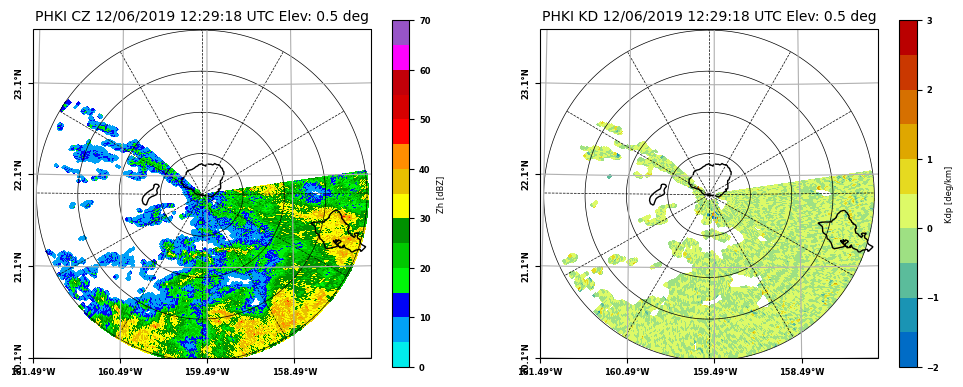

In [10]:
lim = [-200, 200]
two_panel_plot(radar, sweep=0, var1='CZ', vmin1=0, vmax1=70,
               cmap1=discrete_cmap(14,'pyart_NWSRef'), var2='KD', vmin2=-2, vmax2=3, 
               cmap2=discrete_cmap(10,'pyart_HomeyerRainbow'), units2='Kdp [deg/km]', 
               xlim=lim, ylim=lim, units1='Zh [dBZ]')

### Plot HID Summer and Winter

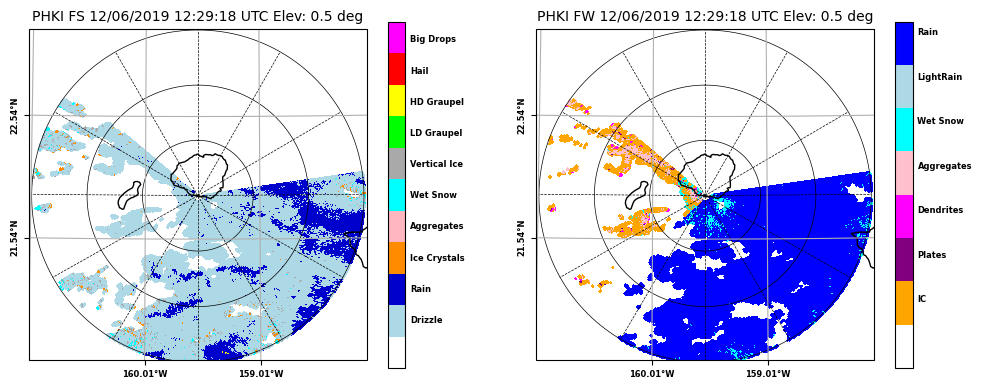

In [11]:
lim = [-150, 150]

# Setup the summre colors.
hid_colors =  ['White','LightBlue','MediumBlue','Darkorange','LightPink','Cyan','DarkGray',
               'Lime','Yellow','Red','Fuchsia']
cmaphid = colors.ListedColormap(hid_colors)

# Setup the winter colors.
hid_colors_winter = ['White','Orange', 'Purple', 'Fuchsia', 'Pink', 'Cyan',
                     'LightBlue', 'Blue']
cmaphidwinter = colors.ListedColormap(hid_colors_winter)

# Plot HIDs
fig, ax1, ax2, display = two_panel_plot(radar, sweep=0, var1='FS', vmin1=0, vmax1=10,
               cmap1=cmaphid, var2='FW', vmin2=0, vmax2=7, 
               cmap2=cmaphidwinter, units2='Winter HID', return_flag=True, 
               xlim=lim, ylim=lim, units1='Summer HID')

display.cbs[0] = adjust_fhc_colorbar_for_pyart(display.cbs[0],'summer')
display.cbs[1] = adjust_fhc_colorbar_for_pyart(display.cbs[1],'winter')

### Plot Liquid and Ice Water Mass

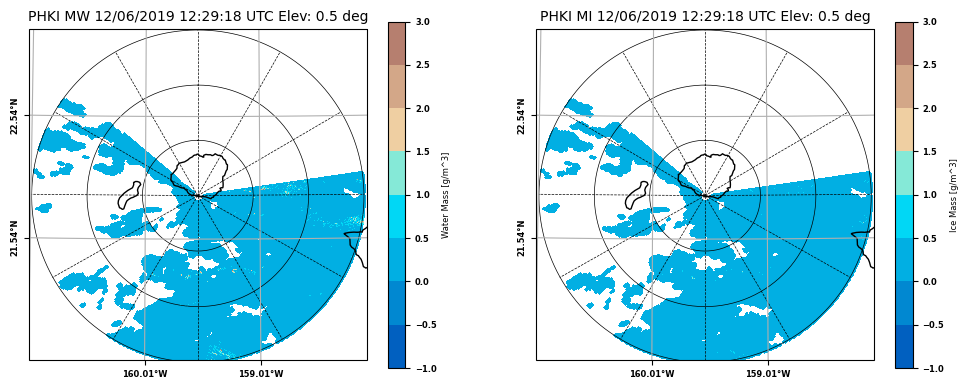

In [12]:
two_panel_plot(radar, sweep=0, var1='MW', vmin1=-1, vmax1=3,
               cmap1=discrete_cmap(8,'pyart_BlueBrown10'), var2='MI', vmin2=-1, vmax2=3, 
               cmap2=discrete_cmap(8,'pyart_BlueBrown10'), units2='Ice Mass [g/m^3]',
               xlim=lim, ylim=lim, units1='Water Mass [g/m^3]')

### Plot DM and NW

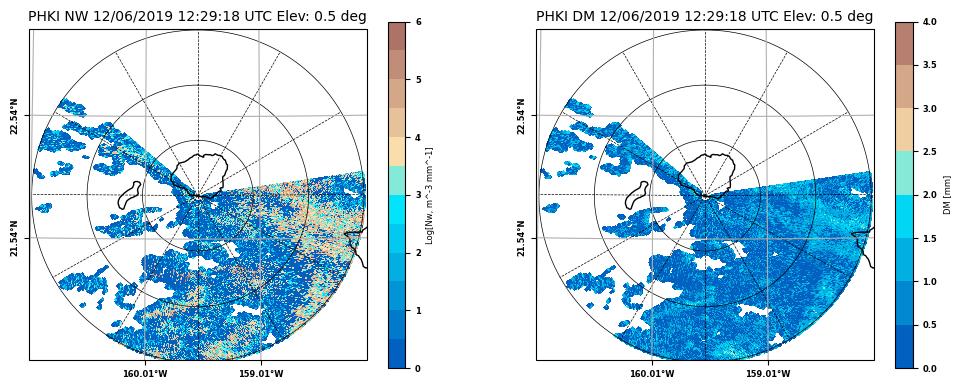

In [13]:
two_panel_plot(radar, sweep=0, var1='NW', vmin1=0, vmax1=6,
               cmap1=discrete_cmap(12, 'pyart_BlueBrown10'), var2='DM', vmin2=0, vmax2=4, 
               cmap2=discrete_cmap(8, 'pyart_BlueBrown10'), units2='DM [mm]', 
               xlim=lim, ylim=lim, units1='Log[Nw, m^-3 mm^-1]')

### Plot RC and RP rain rates

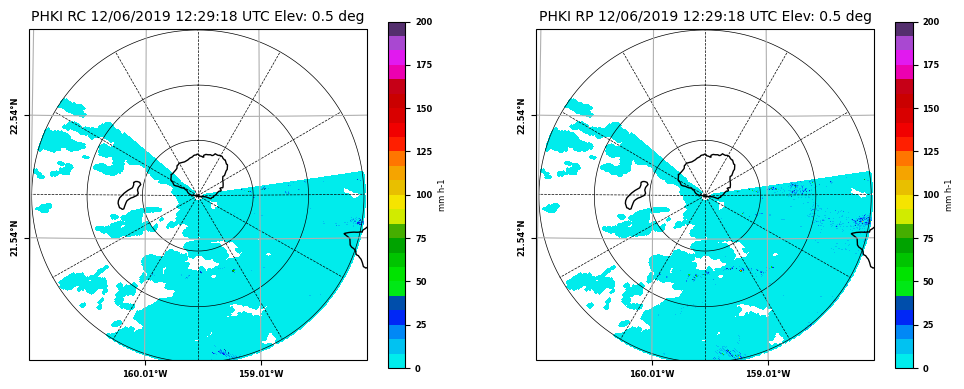

In [14]:
two_panel_plot(radar, sweep=0, var1='RC', vmin1=0, vmax1=200,
               cmap1=discrete_cmap(24,'pyart_NWSRef'), var2='RP', vmin2=0, vmax2=200, 
               cmap2=discrete_cmap(24,'pyart_NWSRef'), units2='mm h-1',
               xlim=lim, ylim=lim, units1='mm h-1')

### Plot Beyond 150 and Blockage fields

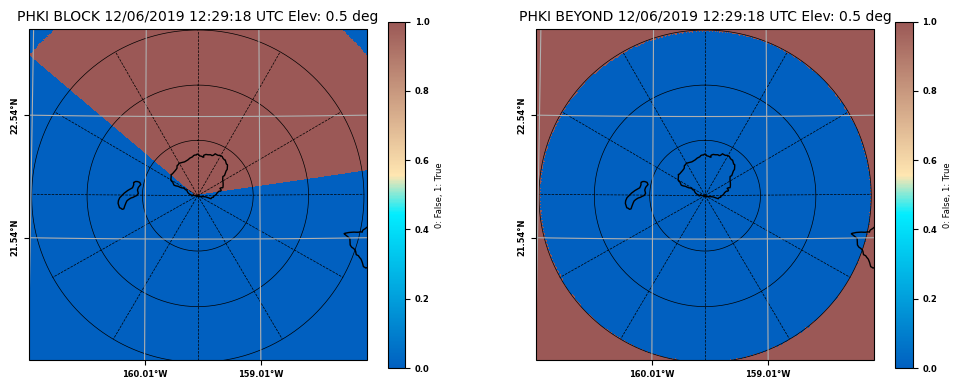

In [15]:
two_panel_plot(radar, sweep=0, var1='BLOCK', vmin1=0, vmax1=1,
               cmap1='pyart_BlueBrown10', var2='BEYOND', vmin2=0, vmax2=1, 
               cmap2='pyart_BlueBrown10', units2='0: False, 1: True',
               xlim=lim, ylim=lim, units1='0: False, 1: True')

### Start Here - DM and NW

In [1]:
def calc_dsd_sband_tokay_2020(dz, zdr, loc='all'):

    dm = 0.0 * dz
    nw = 0.0 * dz
    dz_lin = dbz_to_zlin(dz)
    
    # Force input string to lower case
    loc = loc.lower()
    
    # Compute dm for valid ZDR
    #print('    DSD equation:  ',loc)
    if loc == 'wff':
        high = np.logical_and(zdr > 3.5, zdr <= 4.0)
        dm[high] = get_dm(zdr[high],0.0138,0.1696,1.1592,0.7215)
        low = np.logical_and(zdr <= 3.5, zdr > 0.0)
        dm[low] = get_dm(zdr[low],0.0990,0.6141,1.8364,0.4559)
    elif loc == 'all':
        good_zr = np.logical_and(zdr > 0.0, zdr <= 4.0)
        dm[good_zr] = get_dm(zdr[good_zr],0.0138,0.1696,1.1592,0.7215)
        
    # Compute nw for valid dm and log(nw)
    dm_range = np.logical_and(dm >= 0.5, dm <= 4.0)
    nw[dm_range] = 35.43 * dz_lin[dm_range] * dm[dm_range]**-7.192
    nw[dm_range] = np.log10(nw[dm_range])
    nw_range = np.logical_and(nw >= 0.5, nw <= 6.0)    
    n2 = 0.0 * dz
    n2[nw_range] = nw[nw_range]
    
    # Set dm and nw based on acceptable dm range
    bad_dm = np.less(dm,0.5)
    n2[bad_dm] = n2[bad_dm] * -1.0
    dm[bad_dm] = dm[bad_dm] * -1.0
    
    # Set dm and nw based on acceptable nw range
    bad_nw = np.less(n2,0.5)
    n2[bad_nw] = n2[bad_nw] * -1.0
    dm[bad_nw] = dm[bad_nw] * -1.0

    #print(np.min(n2))
    #print(np.max(n2))
    #print(np.min(dm))
    #print(np.max(dm))
    
    return dm, n2

def get_dm(zdr,a,b,c,d):
    
    return a * zdr**3 - b * zdr**2 + c * zdr + d

### RP

In [7]:
def get_bringi_rainrate_nw(dbz,zdr,kdp,rhv,nw,fh):

    # Calculate the coefficient a' in Z = a' * R^1.5 using the DSD
    # parameters. First, calculate f(mu)
    mu = 3.0
    nw = 10**nw
    rp = get_polzr_rainrate(dbz,nw,mu)
    
    # Max rain rate test
    rr_max = np.greater(rp,300)
    rp[rr_max] = rp[rr_max] * -1.0

    # HID ice threshold
    rp = remove_ice(rp, fh)
    
    # Check if Rain rate is not finite!
    rr_inf = np.isinf(rp)
    rp[rr_inf] = rp[rr_inf] * -1.0
    
    nw = np.log10(nw)
    return rp, nw

def get_polzr_rainrate(dbz,nw,mu):
    
    # From eq. A.25 in Bring et al. 2004
    x1 = 6.0 * (3.67 + mu)**(4+mu)
    x2 = (3.67**4) * gamma(mu+4)
    f_mu = x1/x2

    # From eq. A.23 in Bring et al. 2004
    x3 = f_mu * gamma(7+mu)
    x4 = (3.67+mu)**(7+mu)
    fz_mu = x3/x4

    # From eq. A.24 in Bring et al. 2004
    x5  = np.pi * 0.0006 * 3.78 * f_mu
    x6  = gamma(4.67 + mu) / (3.67+mu)**(4.67+mu)

    fr_mu = x5 * x6
    
    a_mu = fz_mu / (fr_mu**(1.5))

    # Now, the new A parameter for the Z-R relation is given by:
    # a' = a_mu/(nw^1.5) 

    a_prime = a_mu/(nw**0.5)
    b = 1.5
    rp =  get_zr_rain(dbz, a_prime, b)

    return rp

def get_zr_rain(dbz, a, b):
    
    # Set max_dbz dB as maximum reasonable reflectivity
    max_dbz = 55
    dbz_max = np.greater_equal(dbz,max_dbz)
    dbz[dbz_max] = max_dbz

    # Now calculate the rain rate from the pass dBZ value
    zh = 10**(dbz/10.0)
    rp = (zh/a)**(1.0/b)
    
    return rp

### Threshold tests - set ice to -999 and low dBZ zalues to 0.0

In [3]:
def remove_ice(fl, fh):
    
    hid_ice = [0, 3, 4, 5, 6, 7, 8, 9]
    for xice in hid_ice:
        ice = np.equal(fh, xice)
        fl[ice] = -999
        
    return fl

def set_low_dbz(fl, zz):

    #Use raw reflectivity since corrected reflectivity masks values <= 5
    low_dbz = np.logical_and(zz > 0, zz <= 5)
    fl[low_dbz] = 0.0
    
    return fl

### Helper Functions

In [4]:
def remove_undesirable_fields(radar):

    cf_fields = ['ZZ','PH','DR','DZ','VR','RH','CZ','KD','SD','DM','NW','FS','FW','MW','MI','RC','RP','BEYOND','BLOCK']
    drop_fields = [i for i in radar.fields.keys() if i not in cf_fields]
    for field in drop_fields:
        radar.fields.pop(field)

    print(' ',"CF FIELDS -->  ", radar.fields.keys(), '', sep='\n')
  
    return radar

def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""
    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N, 0))
    cmap_name = base.name + str(N)
    return plt.cm.colors.ListedColormap(color_list, color_list, N)

def extract_unmasked_data(radar, field, bad=-32767.0):
    """Simplify getting unmasked radar fields from Py-ART"""
    return radar.fields[field]['data'].filled(fill_value=bad)

def add_field_to_radar_object(field, radar, field_name='UN', units='',
                              long_name='UNKNOWN', standard_name='UNKNOWN',
                              dz_field='CZ'):
    
    fill_value = -32767.0
    masked_field = np.ma.asanyarray(field)
    masked_field.mask = masked_field == fill_value,
    if hasattr(radar.fields[dz_field]['data'], 'mask'):
        setattr(masked_field, 'mask',
                np.logical_or(masked_field.mask, radar.fields[dz_field]['data'].mask))
        fill_value = radar.fields[dz_field]['_FillValue']
    field_dict = {'data': masked_field,
                  'units': units,
                  'long_name': long_name,
                  'standard_name': standard_name,
                  '_FillValue': fill_value}
    radar.add_field(field_name, field_dict, replace_existing=True)
    return radar

def two_panel_plot(radar, sweep=0, var1='reflectivity', title1 = ' ', vmin1=0, vmax1=65,
                   cmap1='RdYlBu_r', units1='dBZ', var2='differential_reflectivity', title2 = ' ',
                   vmin2=-5, vmax2=5, cmap2='RdYlBu_r', units2='dB', return_flag=False,
                   xlim=[-150,150], ylim=[-150,150]):
    
    site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep = get_radar_info(radar, sweep)
    title1 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var1,mydate,mytime,elv)
    title2 = '{} {} {} {} UTC Elev: {:2.1f} deg'.format(site,var2,mydate,mytime,elv)
    
    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = xlim[1] * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))

    min_lat = radar_lat - maxrange_meters * meters_to_lat
    max_lat = radar_lat + maxrange_meters * meters_to_lat
    min_lon = radar_lon - maxrange_meters * meters_to_lon
    max_lon = radar_lon + maxrange_meters * meters_to_lon
    min_lon_rn=round(min_lon,2)
    max_lon_rn=round(max_lon,2)
    min_lat_rn=round(min_lat,2)
    max_lat_rn=round(max_lat,2)
    lon_grid = np.arange(min_lon_rn - 1.00 , max_lon_rn + 1.00, 1.0)
    lat_grid = np.arange(min_lat_rn - 1.00 , max_lat_rn + 1.00, 1.0)
    
    SMALL_SIZE = 6
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14

    plt.rc('font', size=SMALL_SIZE, weight='bold') # controls default text sizes
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    projection = ccrs.LambertConformal(radar_lon, radar_lat)
    display = pyart.graph.RadarMapDisplay(radar)
    fig = plt.figure(figsize=(12,4.5))
    
    ax1 = fig.add_subplot(121,projection=projection)
    display.plot_ppi_map(var1, sweep, vmin=vmin1, vmax=vmax1,
                     resolution='10m',
                     title = title1,
                     projection=projection, ax=ax1,
                     cmap=cmap1,
                     colorbar_label=units1,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    ax2 = fig.add_subplot(122,projection=projection)
    display.plot_ppi_map(var2, sweep, vmin=vmin2, vmax=vmax2,
                     resolution='10m',
                     title = title2,
                     projection=projection, ax=ax2,
                     cmap=cmap2,
                     colorbar_label=units2,
                     min_lon=min_lon, max_lon=max_lon,
                     min_lat=min_lat, max_lat=max_lat,
                     lon_lines=lon_grid,lat_lines=lat_grid,
                     add_grid_lines=True,
                     lat_0=radar_lat,
                     lon_0=radar_lon,
                     embellish = True,
                     mask_outside=True)
    
    for rng in range(50,xlim[1]+50,50):
        display.plot_range_ring(rng, line_style='k--', lw=0.5)
    add_radials(radar,display,xlim[1])
    plt.yticks(rotation=90, va = 'center')
    
    if return_flag:
        return fig, ax1, ax2, display

def add_radials(radar,display,max_range):

    radar_lat = radar.latitude['data'][0]
    radar_lon = radar.longitude['data'][0]
    dtor = math.pi/180.0
    maxrange_meters = max_range * 1000.
    meters_to_lat = 1. / 111177.
    meters_to_lon =  1. / (111177. * math.cos(radar_lat * dtor))
    
    for azi in range(0,360,30):
        azimuth = 90. - azi
        dazimuth = azimuth * dtor
        lon_maxrange = radar_lon + math.cos(dazimuth) * meters_to_lon * maxrange_meters
        lat_maxrange = radar_lat + math.sin(dazimuth) * meters_to_lat * maxrange_meters
        display.plot_line_geo([radar_lon, lon_maxrange], [radar_lat, lat_maxrange],
                              line_style='k--',lw=0.5)

def get_radar_info(radar, sweep):
    #
    # *** get radar elevation, date, time
    #
    radar_DT = pyart.util.datetime_from_radar(radar)
    elv=radar.fixed_angle['data'][sweep]
    string_csweep = str(sweep).zfill(2)
    month = str(radar_DT.month).zfill(2)
    day = str(radar_DT.day).zfill(2)
    year = str(radar_DT.year).zfill(4)
    hh = str(radar_DT.hour).zfill(2)
    mm = str(radar_DT.minute).zfill(2)
    ss = str(radar_DT.second).zfill(2)
    mydate = month + '/' + day + '/' + year
    mytime = hh + ':' + mm + ':' + ss
    if 'site_name' in radar.metadata.keys():
        site = radar.metadata['site_name'].upper()
    elif 'instrument_name' in radar.metadata.keys():
        if isinstance(radar.metadata['instrument_name'], bytes):
            site = radar.metadata['instrument_name'].decode().upper()
        else:
            site = radar.metadata['instrument_name'].upper()
    else:
        site=''

    return site, mydate, mytime, elv, year, month, day, hh, mm, ss, string_csweep    
    
def adjust_fhc_colorbar_for_pyart(cb,type='summer'):
    if type == 'summer':
        cb.set_ticks(np.arange(1.4, 10, 0.9))
        cb.ax.set_yticklabels(['Drizzle', 'Rain', 'Ice Crystals', 'Aggregates',
                               'Wet Snow', 'Vertical Ice', 'LD Graupel',
                               'HD Graupel', 'Hail', 'Big Drops'])
    if type == 'winter':
        cb.set_ticks(np.arange(1.4, 7, 0.9))
        cb.ax.set_yticklabels(['IC','Plates', 'Dendrites', 'Aggregates', 'Wet Snow',
                           'LightRain', 'Rain'])

    cb.ax.set_ylabel('')
    cb.ax.tick_params(length=0)

    return cb

def dbz_to_zlin(dz):
    """
    Convert from log [dBZ] to linear Z [mm^6 m^−3] units.
    Parameters
    ----------
    dbz : float or array
        logarithmic reflectivity value
    """
    return 10.**(np.asarray(dz)/10.)

def zlin_to_dbz(Z):
    """
    Convert from linear Z [mm^6 m^−3] to log [dBZ] units.
    Parameters
    ----------
    zlin : float or array
        linear reflectivity units
    """
    return 10. * np.log10(np.asarray(zlin))

def grab_sounding(radar):

    if(site == 'KMQT'):
        sounding_dir = f"{BASE_DIR}/KMQT_2022_1130_02UTC.txt"

    if(site == 'PHKI'):
        sounding_dir = f"{BASE_DIR}/PHKI_2019_1206_12UTC.txt"
    
    soundingb = os.path.basename(sounding_dir)
    #print('    Sounding file -->  ' + soundingb, sep='\n')

    headings = ["PRES","HGHT","TEMP","DWPT","RELH","MIXR","DRCT","SKNT","THTA","THTE","THTV"]
    colspecs = [(3, 9), (11, 18), (20, 26), (28, 34), (36, 38), (40, 42),
                (44, 46), (48, 50), (52, 54), (56, 58), (60, 62)]
    
    sound = pd.read_fwf(sounding_dir, names=headings, header=None, colspecs=colspecs,skiprows=2)

    presssure_pa = sound.PRES
    height_m = sound.HGHT
    temperature_c = sound.TEMP
    dewpoint_c = sound.DWPT

    mydata=dict(zip(('hght','pres','temp','dwpt'),(height_m,presssure_pa,temperature_c,dewpoint_c)))

    sounding=SkewT.Sounding(soundingdata=mydata)
           
    radar_T, radar_z = interpolate_sounding_to_radar(sounding, radar)
    
    add_field_to_radar_object(radar_T, radar, field_name='TEMP', units='deg C',
                                 long_name='Temperature',
                                 standard_name='Temperature',
                                 dz_field='CZ')

    add_field_to_radar_object(radar_z, radar, field_name='HEIGHT', units='km',
                                 long_name='Height',
                                 standard_name='Height', 
                                 dz_field='CZ')

    expected_ML = retrieve_ML(mydata)
    
    return radar, expected_ML

def radar_coords_to_cart(rng, az, ele, debug=False):

    theta_e = ele * np.pi / 180.0  # elevation angle in radians.
    theta_a = az * np.pi / 180.0  # azimuth angle in radians.
    R = 6371.0 * 1000.0 * 4.0 / 3.0  # effective radius of earth in meters.
    r = rng * 1000.0  # distances to gates in meters.

    z = (r ** 2 + R ** 2 + 2.0 * r * R * np.sin(theta_e)) ** 0.5 - R
    s = R * np.arcsin(r * np.cos(theta_e) / (R + z))  # arc length in m.
    x = s * np.sin(theta_a)
    y = s * np.cos(theta_a)
    return x, y, z

def get_z_from_radar(radar):
    """Input radar object, return z from radar (km, 2D)"""
    azimuth_1D = radar.azimuth['data']
    elevation_1D = radar.elevation['data']
    srange_1D = radar.range['data']
    sr_2d, az_2d = np.meshgrid(srange_1D, azimuth_1D)
    el_2d = np.meshgrid(srange_1D, elevation_1D)[1]
    xx, yy, zz = radar_coords_to_cart(sr_2d/1000.0, az_2d, el_2d)
    return zz + radar.altitude['data']

def check_sounding_for_montonic(sounding):
    """
    So the sounding interpolation doesn't fail, force the sounding to behave
    monotonically so that z always increases. This eliminates data from
    descending balloons.
    """
    snd_T = sounding.soundingdata['temp']  # In old SkewT, was sounding.data
    snd_z = sounding.soundingdata['hght']  # In old SkewT, was sounding.data
    dummy_z = []
    dummy_T = []
    if not snd_T.mask[0]: #May cause issue for specific soundings
        dummy_z.append(snd_z[0])
        dummy_T.append(snd_T[0])
        for i, height in enumerate(snd_z):
            if i > 0:
                if snd_z[i] > snd_z[i-1] and not snd_T.mask[i]:
                    dummy_z.append(snd_z[i])
                    dummy_T.append(snd_T[i])
        snd_z = np.array(dummy_z)
        snd_T = np.array(dummy_T)
    return snd_T, snd_z

def interpolate_sounding_to_radar(sounding, radar):
    """Takes sounding data and interpolates it to every radar gate."""
    radar_z = get_z_from_radar(radar)
    radar_T = None
    snd_T, snd_z = check_sounding_for_montonic(sounding)
    shape = np.shape(radar_z)
    rad_z1d = radar_z.ravel()
    rad_T1d = np.interp(rad_z1d, snd_z, snd_T)
    return np.reshape(rad_T1d, shape), radar_z

def retrieve_ML(mydata):

    # Retrieve expected ML for winter HID

    is_all_neg = np.all(mydata['temp'] < 0)
    if is_all_neg:
        expected_ML = 0
    else:
        a = mydata['temp']
        idx=np.where(np.diff(np.sign(a)) != 0)[0] + 1
        int1 = (idx[0])
        int2 = int1 - 1
        atol = a[int2] + a[int2]
        wh0 = np.where(np.isclose(np.abs(mydata['temp']),0.0,atol=atol))
        try:
            expected_ML = np.array(mydata['hght'])[wh0[0]][0]/1000.
        except:
            expected_ML = 0
    
    #print('    Expected ML:  ',expected_ML)   

    return expected_ML

 ### Beyond 150 set to -32767.0 and Blockage mask set to -888

In [5]:
def mask_beyond_150(radar):

    """
    Filter out any data outside 150 KM set to missing(-32767.0)
    """
    
    sector = {'hmin': 0, 'hmax': None,
              'rmin': 150 * 1000, 'rmax':  400 * 1000,
              'azmin': 0, 'azmax': 360,
              'elmin': 0, 'elmax': None}
    
    beyond_flag = np.ma.ones((radar.nrays, radar.ngates), dtype=int)
    
    # check for altitude limits
    if sector['hmin'] is not None:
        beyond_flag[radar.gate_altitude['data'] < sector['hmin']] = 0
    if sector['hmax'] is not None:
        beyond_flag[radar.gate_altitude['data'] > sector['hmax']] = 0

    # check for range limits

    if sector['rmin'] is not None:
        beyond_flag[:, radar.range['data'] < sector['rmin']] = 0

    if sector['rmax'] is not None:
        beyond_flag[:, radar.range['data'] > sector['rmax']] = 0

    # check elevation angle limits
    if sector['elmin'] is not None:
        beyond_flag[radar.elevation['data'] < sector['elmin'], :] = 0

    if sector['elmax'] is not None:
        beyond_flag[radar.elevation['data'] > sector['elmax'], :] = 0

    # check min and max azimuth angle
    if sector['azmin'] is not None and sector['azmax'] is not None:
        if sector['azmin'] <= sector['azmax']:
            beyond_flag[radar.azimuth['data'] < sector['azmin'], :] = 0
            beyond_flag[radar.azimuth['data'] > sector['azmax'], :] = 0
        if sector['azmin'] > sector['azmax']:
            beyond_flag[np.logical_and(
            radar.azimuth['data'] < sector['azmin'],
            radar.azimuth['data'] > sector['azmax']), :] = 0
    elif sector['azmin'] is not None:
        beyond_flag[radar.azimuth['data'] < sector['azmin'], :] = 0
    elif sector['azmax'] is not None:
        beyond_flag[radar.azimuth['data'] > sector['azmax'], :] = 0

    beyond_field = beyond_flag
    apply_beyond = np.equal(beyond_field,1)
    
    fields = ['FS','FW','RC','RP','MW','MI','DM','NW']
    for fld in fields:
        nf = radar.fields[fld]['data']
        nf[apply_beyond] = -32767.0
        radar.add_field_like(fld,fld,nf,replace_existing=True)

    beyond_dict = {"data": beyond_field, "units": "0: False, 1: True",
                   "long_name": "BEYOND", "_FillValue": -32767.0,
                   "standard_name": "BEYOND",}
    radar.add_field("BEYOND", beyond_dict, replace_existing=True)    
    
    return radar

def set_blockage(radar, sector_dict):

    """
    Set known blocages to -888
    """

    for k in range(len(sector_dict)):
        
        sector = sector_dict[k]
        
        block_flag = np.ma.ones((radar.nrays, radar.ngates), dtype=int)
    
        # check for altitude limits
        if sector['hmin'] is not None:
            block_flag[radar.gate_altitude['data'] < sector['hmin']] = 0
        if sector['hmax'] is not None:
            block_flag[radar.gate_altitude['data'] > sector['hmax']] = 0

        # check for range limits

        if sector['rmin'] is not None:
            block_flag[:, radar.range['data'] < sector['rmin']] = 0

        if sector['rmax'] is not None:
            block_flag[:, radar.range['data'] > sector['rmax']] = 0

        # check elevation angle limits
        if sector['elmin'] is not None:
            block_flag[radar.elevation['data'] < sector['elmin'], :] = 0

        if sector['elmax'] is not None:
            block_flag[radar.elevation['data'] > sector['elmax'], :] = 0

        # check min and max azimuth angle
        if sector['azmin'] is not None and sector['azmax'] is not None:
            if sector['azmin'] <= sector['azmax']:
                block_flag[radar.azimuth['data'] < sector['azmin'], :] = 0
                block_flag[radar.azimuth['data'] > sector['azmax'], :] = 0
            if sector['azmin'] > sector['azmax']:
                block_flag[np.logical_and(
                radar.azimuth['data'] < sector['azmin'],
                radar.azimuth['data'] > sector['azmax']), :] = 0
        elif sector['azmin'] is not None:
            block_flag[radar.azimuth['data'] < sector['azmin'], :] = 0
        elif sector['azmax'] is not None:
            block_flag[radar.azimuth['data'] > sector['azmax'], :] = 0
         
        globals()['block_flag_%s' % k] = block_flag 
    
    block_flag = np.ma.zeros((radar.nrays, radar.ngates), dtype=int)
    for k in range(len(sector_dict)):
        globals()['apply_block_%s' % k] = np.equal(globals()['block_flag_%s' % k],1)
        block_flag[globals()['apply_block_%s' % k]] = 1
    
    block_field = block_flag
    apply_block = np.equal(block_flag,1)
    
    fields = ['CZ','DR','KD','PH','RH','SD','SW','VR','FS','FW','RC','RP','MW','MI','DM','NW']
    for fld in fields:
        nf = radar.fields[fld]['data']
        nf[apply_block] = -888
        radar.add_field_like(fld,fld,nf,replace_existing=True)
    
    block_dict = {"data": block_field, "units": "0: False, 1: True",
                  "long_name": "BLOCK", "_FillValue": -32767.0,
                  "standard_name": "BLOCK",}
    radar.add_field("BLOCK", block_dict, replace_existing=False)
    
    return radar